In [36]:
from preprocessing import Audio
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sp
import librosa as li
import librosa.display
import IPython.display as ipd

%matplotlib inline
#tf.debugging.set_log_device_placement(True)

In [2]:
GPU = tf.config.list_logical_devices('GPU')
CPU = tf.config.list_logical_devices('CPU')
DEVICE = GPU[0].name if GPU else CPU[0].name
DEVICE

'/device:GPU:0'

<h1>Подготовка данных для обучения и тестирования</h1>

In [41]:
def get_data():
    def norm(x):
        std = np.std(x ,ddof=1)
        return (x - np.mean(x)) / std

    PATH_0 = r'F:\NewData\Done\1'
    PATH_1 = r'F:\NewData\Done\2'

    PATHS = li.util.find_files(PATH_0)[:10000] + li.util.find_files(PATH_1)

    np.random.shuffle(PATHS)

    SOUNDS = [Audio(path) for path in PATHS]
    DATA = []
    LABELS = []

    for sound in SOUNDS:
        DATA.append(norm(sound.e_parts))
        LABELS.append(sound.label)

    return (np.array(DATA), np.array(LABELS))

In [42]:
data, labels = get_data()

In [43]:
len(data)

10081

<h1>Создание модели нейронной сети</h1>

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),
                          input_shape=(20, )),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 22        
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


# Клонирование модели для transfer learning

In [ ]:
model = tf.keras.models.load_model('AudRec_L2_v2.5-5(20_units).h5')
model = tf.keras.models.clone_model(mosel)
model.summary()

<h1>Обучение</h1>

In [56]:
def print_metrics(model, data, y, i=None, history=None):

    y_pred = model.predict_classes(data)

    prescision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    auc = tf.keras.metrics.AUC()
    loss = tf.keras.metrics.SparseCategoricalCrossentropy()

    _ = prescision.update_state(y, y_pred)
    _ = recall.update_state(y, y_pred)
    _ = auc.update_state(y, y_pred)
    _ = loss.update_state(y, model.predict(data))

    if history != None:
        history['precision'].append(prescision.result().numpy())
        history['recall'].append(recall.result().numpy())
        history['auc'].append(auc.result().numpy())
        history['loss'].append(loss.result().numpy())

    if i != None and i % 100 == 0:
        print('Epoch ', i, end=': ')
        print('Loss : {:.4f} - Precision : {:.4f} - Recall : {:.4f} - AUC : {:.4f}'.format(
            loss.result().numpy(),
            prescision.result().numpy(),
            recall.result().numpy(),
            auc.result().numpy()
        ))
    elif i == None:
        print('Loss : {:.4f} - Precision : {:.4f} - Recall : {:.4f} - AUC : {:.4f}'.format(
            loss.result().numpy(),
            prescision.result().numpy(),
            recall.result().numpy(),
            auc.result().numpy()
        ))

In [58]:
history = dict({
    'precision' : [],
    'recall' : [],
    'auc' : [],
    'loss' : []
})


for i in range(0, 1001):
    with tf.device(device_name=DEVICE):
        model.fit(data, labels, epochs=1, verbose=0) 
    print_metrics(model, data, labels, i, history=history)

Epoch  0: Loss : 0.0340 - Precision : 0.0000 - Recall : 0.0000 - AUC : 0.5000
Epoch  100: Loss : 0.0334 - Precision : 0.0000 - Recall : 0.0000 - AUC : 0.5000
Epoch  200: Loss : 0.0338 - Precision : 0.0000 - Recall : 0.0000 - AUC : 0.5000


KeyboardInterrupt: 

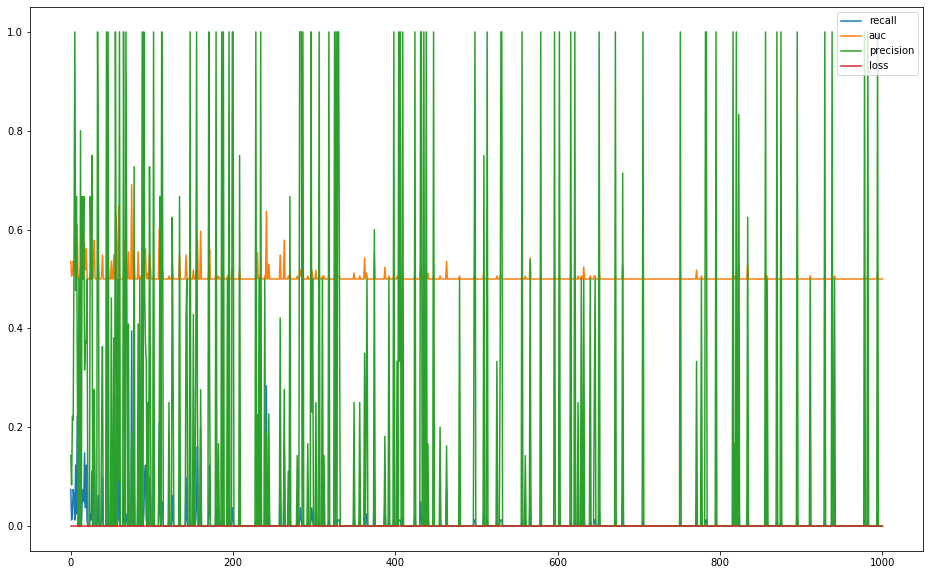

In [48]:
plt.figure(figsize=(16, 10))
plt.plot(history['recall'], label='recall')
plt.plot(history['auc'], label='auc')
plt.plot(history['precision'], label='precision')
plt.plot(history['loss'], label='loss')
plt.legend()

In [34]:
model.save('AudRec_L2_v2.5-5(20_units).h5')

In [81]:
data[0]

array([-0.60548782, -0.6052156 , -0.60238858, -0.58856599, -0.53623857,
       -0.48855356,  0.44107259,  2.30568212,  2.28383701,  0.27126242,
        1.41861301,  1.25588264, -0.35391036, -0.56722348, -0.60132463,
       -0.60548728, -0.60548848, -0.60548848, -0.60548848, -0.60548848])

In [25]:
model = tf.keras.models.load_model('AudRec_L2_v2.2(100).h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [86]:
pred = 0

for i in range(len(labels)):
    with tf.device(DEVICE):
        p = model.predict_classes(np.reshape(data[i], (1, 20)))
    if p[0] == 1:
        pred += 1

print(pred)

 RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset

In [84]:
d = data[1]
print(model.predict_classes(np.reshape(d, (1, 20))))
print(model.predict(np.reshape(d, (1, 20))))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
[0]
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [85]:
labels[1]

array([0])

In [13]:
model.evaluate(data, labels)

1081/1081 [==============================] - 0s 117us/sample - loss: 0.1103 - accuracy: 0.9611


[0.11025124553256736, 0.96114707]

In [162]:
m = tf.keras.models.load_model('AudRec_L2_v2.3(92).h5')

In [14]:
pred = model.predict_classes(data)

In [148]:
pred.shape

(1081,)

In [18]:
print_metrics(model, labels, pred)

Precision : 0.8421052694320679 - Recall : 0.5925925970077515 - AUC : 0.7917962670326233


In [20]:
pred[3]

0

In [15]:
s = []
for i in range(1081):
    if pred[i] == 1:
        s.append(i)

print(len(s))

57


In [16]:
57/81

0.7037037037037037

In [23]:
def norm(x):
    std = np.std(x ,ddof=1)
    return (x - np.mean(x)) / std

def func(_x, _sr=44100):
 
    x = tf.keras.preprocessing.sequence.pad_sequences(
        [np.reshape(_x, len(_x))], 
        maxlen=int(44100 * 0.4), 
        padding='post',
        truncating='post',
        dtype='float32'
    )[0]
    coeff = sp.signal.firwin(999, [260, 700], fs=_sr, pass_zero=False)
    x_filtered = sp.signal.lfilter(coeff, 1.0, x)
    x_normalized = x_filtered/x_filtered.max()
    x_squared = np.square(x_normalized)
    splited = np.array_split(x_squared, 20)
    e_parts = np.empty((0))
    for part in splited:
        e_parts = np.append(e_parts, sp.integrate.simps(part))
    
    # e_parts = np.reshape(norm(e_parts), (20,))
    return np.reshape(norm(e_parts), (1, 20))

In [24]:
d = func(data[0])
print(d)

[[ 4.24852913 -0.22316946 -0.22363109 -0.22363109 -0.22363109 -0.22363109
  -0.22363109 -0.22363109 -0.22363109 -0.22363109 -0.22363109 -0.22363109
  -0.22363109 -0.22363109 -0.22363109 -0.22363109 -0.22363109 -0.22363109
  -0.22363109 -0.22363109]]


In [164]:
m.predict(np.reshape(data[3], (1, 20)))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


array([[0.66608596, 0.33391407]], dtype=float32)

In [153]:
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [155]:
with tf.device(DEVICE):
     history = m.fit(data, labels, epochs=100)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 1081 samples
Epoch 1/100
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_467878 in device /job:localhost/replica:0/task:0/device:GPU:0
1081/1081 [===========================